In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy
import scipy.signal as signal
import copy as copy

In [14]:
class Qsystem:
    def __init__(self, n, psi, w, gamma = 0):
        self.n = n
        self.gamma = gamma
        self.psi = np.array(psi, dtype = complex)
        self.psi = self.psi / np.linalg.norm(self.psi)
        self.psi.shape = (self.n, 1)
        self.w = np.array(w)
        if (self.w.size == 1) & (n > 2):
            self.w = np.array([w] * (n - 1))
            
class Drive:
    def __init__(self, Time, steps, tstart, long, amplitude, shape = 'no', w = 0):
        if shape == 'sin':
            self.drive = np.zeros((steps + 1))
            dt = Time / steps
            step_start = max(round(tstart / dt), 0)
            step_end = min(round((tstart + long) / dt), steps)
            #for i in range(step_start, step_end + 1):
                #self.drive[i] = amplitude * np.sin(w * i * dt)
            self.drive[step_start : step_end + 1] = amplitude * np.sin(w * np.arange(step_end + 1 - step_start) * dt)
            print(w)
            print(amplitude)
            print(self.drive)
            
class Operator:
    def __init__(self, L1, L2):
        I1 = np.identity(L1, dtype = complex)
        I2 = np.identity(L2, dtype = complex)
        self.a1 = np.sqrt(np.diag(np.arange(1, L1), k = 1))
        self.a1d = self.a1.transpose()
        self.a2 = np.sqrt(np.diag(np.arange(1, L2), k = 1))
        self.a2d = self.a2.transpose()
        self.a1 = np.kron(self.a1, I2)
        self.a1d = np.kron(self.a1d, I2)
        self.a2 = np.kron(I1, self.a2)
        self.a2d = np.kron(I1, self.a2d)

def A(psi_in, L1, L2, num, rwa): # вф, номер осциллятора (1(строки) или 2(столбцы))
    psi = copy.copy(np.asarray(psi_in, dtype=np.complex))
    if num == 1:
        psi = np.append(psi[L2:], np.zeros(L2)) * np.repeat(np.append(np.sqrt(np.arange(1, L1, 1)) * rwa, 0.), L2, axis = 0)
    if num == 2:
        psi = np.transpose(np.reshape(psi, (L1, L2)))
        psi[0, :] = np.zeros(L1)
        psi = np.ravel(np.transpose(np.roll(psi, -1, axis = 0)))
        psi = psi * np.tile(np.append(np.sqrt(np.arange(1, L2, 1)) * rwa, 0.), L1)    
    return(psi.reshape(L1 * L2, 1))

def Ad(psi_in, L1, L2, num, rwad): # вф, номер осциллятора (1(строки) или 2(столбцы))
    psi = copy.copy(np.asarray(psi_in, dtype=np.complex))
    if num == 1:     
        psi =  np.append(np.zeros(L2), psi[:-L2]) * np.repeat(np.append(np.zeros(1), np.sqrt(np.arange(1, L1, 1)) * rwad), L2, axis = 0)
    if num == 2:
        psi = np.transpose(np.reshape(psi, (L1, L2)))
        psi = np.roll(psi, 1, axis = 0)
        psi[0, :] = np.zeros(L1)
        psi = np.ravel(np.transpose(psi))
        psi = psi * np.tile(np.append(np.zeros(1), np.sqrt(np.arange(1, L2, 1)) * rwad), L1)  
    return(psi.reshape(L1 * L2, 1))

def AdA(psi_in, L1, L2, num): # вф, номер осциллятора (1(строки) или 2(столбцы))
    psi = copy.copy(np.reshape(np.asarray(psi_in, dtype=np.complex), (L1, L2)))
    if num == 1:
        psi *= np.reshape(np.arange(L1), (-1, 1))
    if num == 2:
        psi *= np.arange(L2)
    return(psi.reshape(L1 * L2, 1))

def Nq(psi_in, L1, L2, rwa, rwad): # (A + Ad)
    psi = copy.copy(np.asarray(psi_in, dtype=np.complex))
    if (L1 == 3):
        nq_elements = np.sqrt(np.array([1, 2]))
        psi =  np.append(np.zeros(L2), psi[:-L2]) * np.repeat(np.append(np.zeros(1), nq_elements * rwad), L2, axis = 0) +\
            np.append(psi[L2:], np.zeros(L2)) * np.repeat(np.append(nq_elements * rwa, 0.), L2, axis = 0)
    return(psi.reshape(L1 * L2, 1))

In [3]:
def RunTrajectory(q, r, Time, steps, g, noise, drive):
    dt = Time / steps
    x1 = np.zeros((steps + 1), dtype = complex)
    y1 = np.zeros((steps + 1), dtype = complex)
    z1 = np.zeros((steps + 1), dtype = complex)
    x2 = np.zeros((steps + 1), dtype = complex)
    y2 = np.zeros((steps + 1), dtype = complex)
    z2 = np.zeros((steps + 1), dtype = complex)
    J2 = np.zeros((steps + 1))
    Psi = np.zeros((steps + 1, q.n * r.n, 1), dtype = complex)
    psi = np.kron(q.psi, r.psi)
    rwa1 = np.array([1] * (q.n - 1), dtype = complex)
    rwad1 = np.array([1] * (q.n - 1), dtype = complex)
    rwa2 = np.array([1] * (r.n - 1), dtype = complex)
    rwad2 = np.array([1] * (r.n - 1), dtype = complex)
    
    for i in range(0, steps):   
        a1 = A(psi, q.n, r.n, 1, rwa1); ad1 = Ad(psi, q.n, r.n, 1, rwad1); ada1 = AdA(psi, q.n, r.n, 1)
        a2 = A(psi, q.n, r.n, 2, rwa2); ad2 = Ad(psi, q.n, r.n, 2, rwad2); ada2 = AdA(psi, q.n, r.n, 2)
        
        '''a1 = AA(psi, q.n, r.n, 1, rwa1); ad1 = Add(psi, q.n, r.n, 1, rwad1); ada1 = AdA(psi, q.n, r.n, 1)
        a2 = AA(psi, q.n, r.n, 2, rwa2); ad2 = Add(psi, q.n, r.n, 2, rwad2); ada2 = AdA(psi, q.n, r.n, 2)'''
        
        Psi[i, :] = psi
        x1[i] = np.dot(np.conj(psi.transpose()), ad1) + np.dot(np.conj(psi.transpose()), a1)
        y1[i] = 1j * (np.dot(np.conj(psi.transpose()), ad1) - np.dot(np.conj(psi.transpose()), a1))
        z1[i] = np.dot(np.conj(psi.transpose()), ada1)
        x2[i] = np.dot(np.conj(psi.transpose()), ad2) + np.dot(np.conj(psi.transpose()), a2)
        y2[i] = 1j * (np.dot(np.conj(psi.transpose()), ad2) - np.dot(np.conj(psi.transpose()), a2))
        z2[i] = np.dot(np.conj(psi.transpose()), ada2)
        J2[i] = (np.real(x2[i])/2* np.sqrt(r.gamma) + random.gauss(0, 1)/np.sqrt(dt))
        
       # Nq(a2 + ad2, q.n, r.n, rwa1, rwad1)  (A(ad2, q.n, r.n, 1, rwa1) + Ad(a2, q.n, r.n, 1, rwad1))
        
        '''psi = psi - 1j * dt * g * (A(ad2, q.n, r.n, 1, rwa1) + Ad(a2, q.n, r.n, 1, rwad1)) \
                    + 1j * drive[0].drive[i] * (ad1 + a1) \
                    + 1j * drive[1].drive[i] * (ad2 + a2) \
                    - r.gamma * ada2 * dt / 2\
                    + J2[i] * a2 * np.sqrt(r.gamma) * dt'''
        
        k1 = Evolution(psi, q, r, rwa1, rwad1, rwa2, rwad2, J2, drive, i)
        k2 = Evolution(psi + dt/2 * k1, q, r, rwa1, rwad1, rwa2, rwad2, J2, drive, i)
        k3 = Evolution(psi + dt/2 * k2, q, r, rwa1, rwad1, rwa2, rwad2, J2, drive, i)
        k4 = Evolution(psi + dt * k3, q, r, rwa1, rwad1, rwa2, rwad2, J2, drive, i)
        psi = psi + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
       
        psi = psi / np.linalg.norm(psi)
        
        rwa1 = rwa1 * np.exp(-1j * q.w * dt)
        rwad1 = rwad1 * np.exp(1j * q.w * dt)
        rwa2 = rwa2 * np.exp(-1j * r.w * dt)
        rwad2 = rwad2 * np.exp(1j * r.w * dt)
        
    Psi[steps, :] = psi 
    x1[steps] = np.dot(np.conj(psi.transpose()), ad1) + np.dot(np.conj(psi.transpose()), a1)
    y1[steps] = 1j * (np.dot(np.conj(psi.transpose()), ad1) - np.dot(np.conj(psi.transpose()), a1))
    z1[steps] = np.dot(np.conj(psi.transpose()), ada1)
    x2[steps] = np.dot(np.conj(psi.transpose()), ad2) + np.dot(np.conj(psi.transpose()), a2)
    y2[steps] = 1j * (np.dot(np.conj(psi.transpose()), ad2) - np.dot(np.conj(psi.transpose()), a2))
    z2[steps] = np.dot(np.conj(psi.transpose()), ada2)
    J2[steps] = (np.real(x2[steps])/2* np.sqrt(r.gamma) + random.gauss(0, 1)/np.sqrt(dt))
    
    p0 = np.zeros((steps + 1), dtype = complex)
    p1 = np.zeros((steps + 1), dtype = complex)
    for j in range(0, r.n):
        p0 = p0 + np.abs(Psi[:, 0 * r.n + j, 0]) ** 2
        p1 = p1 + np.abs(Psi[:, 1 * r.n + j, 0]) ** 2    
    return(p0, p1, x1, y1, z1, x2, y2, z2, J2)

In [4]:
def SimulateTrajectories(N, q, r, Time, steps, g, noise, drive):
    t = np.linspace(0, Time, steps + 1)
    p0, p1, x1, y1, z1, x2, y2, z2, J2 = [], [], [], [], [], [], [], [], []
    p0s, p1s, x1s, y1s, z1s, x2s, y2s, z2s, J2s = [], [], [], [], [], [], [], [], []
    fig, (f1, f2) = plt.subplots(
        nrows = 2, ncols = 1,
        figsize=(15, 10)
    )
    for k in range(0, N):
        outputs = RunTrajectory(q, r, Time, steps, g, noise, drive)
        (p0s, p1s, x1s, y1s, z1s, x2s, y2s, z2s, J2s) = outputs
        
        p0.append(p0s)
        p1.append(p1s)
        x1.append(x1s)
        y1.append(y1s)
        z1.append(z1s)
        x2.append(x2s)
        y2.append(y2s)
        z2.append(z2s)
        J2.append(J2s)

        f1.plot(t, np.abs(z1s), label = '<n' + str(k) + '>')
        f2.plot(t, np.real(x1s), label = '<x' + str(k) + '>')
        f2.plot(t, np.real(y1s), label = '<y' + str(k) + '>')
        f2.plot(t, 2.*np.real(z1s)-1., label = '<z' + str(k) + '>')
        
        print('run', k)
        
    f1.set_title('traj energy')
    f2.set_title('traj (x)')
    #f1.legend()
    f2.legend()
    plt.show()
    
    '''b = qt.Bloch()
    b.point_marker = 'o'
    b.point_color = 'b'
    for i in range (0, steps):
        b.add_points((np.real(x1s[i]), np.real(y1s[i]), 2.0 * np.real(z1s[i]) - 1.0))
    b.show()'''
    
    p0m, p1m, x1m, y1m, z1m, x2m, y2m, z2m, J2m = np.mean((p0, p1, x1, y1, z1, x2, y2, z2, J2), axis=1)
    #p0m, p1m, x1m, y1m, z1m, x2m, y2m, z2m, J2m, J2a2dtm = [], [], [], [], [], [], [], [], [], []
    #p0m = np.mean(p0, axis = 0)
    #p1m = np.mean(p1, axis = 0)
    #x1m = np.mean(x1, axis = 0)
    #y1m = np.mean(y1, axis = 0)
    #z1m = np.mean(z1, axis = 0)
    #x2m = np.mean(x2, axis = 0)
    #y2m = np.mean(y2, axis = 0)
    #z2m = np.mean(z2, axis = 0)
    #J2m = np.mean(J2, axis = 0)
    #J2a2dtm = np.mean(J2a2dt, axis = 0)
    
    fig, (f1, f2) = plt.subplots(
        nrows = 1, ncols = 2,
        figsize=(12, 4)
    )
    f1.plot(t, np.real(x1m), label = '$<x>$')
    f1.plot(t, np.real(y1m), label = '$<y>$')
    f1.plot(t, np.abs(z1m), label = '$<n>$')
    f2.plot(t, np.real(x2m), label = '$<x>$')
    f2.plot(t, np.real(y2m), label = '$<y>$')
    f2.plot(t, np.abs(z2m), label = '$<n>$')
    
    f2.plot(t+(np.argmax(np.abs(z2m) - 10.)*t[1]), np.amax(np.abs(z2m))*np.exp(-r.gamma * t))
    
    f1.set_xlabel('time')
    f2.set_xlabel('time')
    f1.legend()
    f2.legend()
    f1.set_title('qubit (mean)')
    f2.set_title('cavity (mean)')
    plt.show()
    
    fig, (f1, f2) = plt.subplots(
        nrows = 1, ncols = 2,
        figsize=(12, 4)
    )
    f1.plot(t, np.real(p0m), label = 'p0')
    f1.plot(t, np.real(p1m), label = 'p1')
    f2.plot(t, np.real(J2m), label = 'J2')
    f1.set_ylabel('probability')
    f1.set_xlabel('time')
    f2.set_ylabel('x noise')
    f2.set_xlabel('time')
    f1.legend()
    f2.legend()
    f1.set_title('qubit, probabilities')
    f2.set_title('x noise in cavity')
    plt.show()
    return(J2m, J2, x2, x2m, z1)

In [5]:
def Evolution(psi, q, r, rwa1, rwad1, rwa2, rwad2, J2, drive, i):
    a2 = A(psi, q.n, r.n, 2, rwa2); ad2 = Ad(psi, q.n, r.n, 2, rwad2); ada2 = AdA(psi, q.n, r.n, 2)
    a1 = A(psi, q.n, r.n, 1, rwa1); ad1 = Ad(psi, q.n, r.n, 1, rwad1);
    psi1 = - 1j * g * Nq(a2 + ad2, q.n, r.n, rwa1, rwad1) \
                    + 1j * drive[0].drive[i] * (ad1 + a1) \
                    + 1j * drive[1].drive[i] * (ad2 + a2) \
                    - r.gamma * ada2 / 2\
                    + J2[i] * a2 * np.sqrt(r.gamma)
    return(psi1)

In [6]:
def Evolution1(psi, q, r, rwa1, rwad1, rwa2, rwad2, J2, drive, i):
    a2 = A(psi, q.n, r.n, 2, rwa2); ad2 = Ad(psi, q.n, r.n, 2, rwad2); ada2 = AdA(psi, q.n, r.n, 2)
    a1 = A(psi, q.n, r.n, 1, rwa1); ad1 = Ad(psi, q.n, r.n, 1, rwad1);
    psi1 = - 1j * g * (A(ad2, q.n, r.n, 1, rwa1) + Ad(a2, q.n, r.n, 1, rwad1)) \
                    + 1j * drive[0].drive[i] * (ad1 + a1) \
                    + 1j * drive[1].drive[i] * (ad2 + a2) \
                    - r.gamma * ada2 / 2\
                    + J2[i] * a2 * np.sqrt(r.gamma)
    return(psi1)

41.17584960095227
0
[ 0.  0.  0. ...  0.  0. -0.]
31.622768996210283
0.1
[0.         0.03109835 0.0591127  ... 0.09909246 0.0983592  0.08787172]
wr 31.622768996210283
Time, steps, N, g, noise
10 1000 1 0.08976158529836757 1
run 0


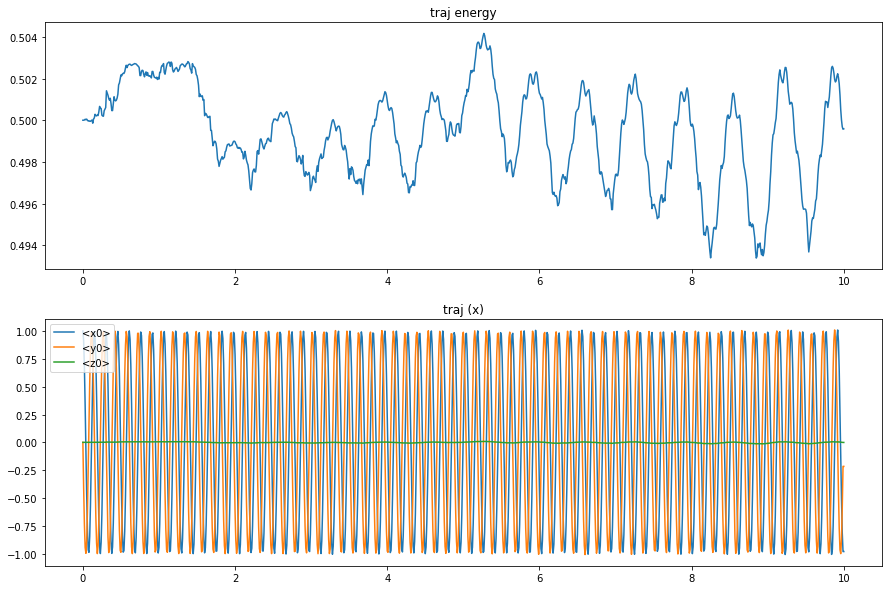

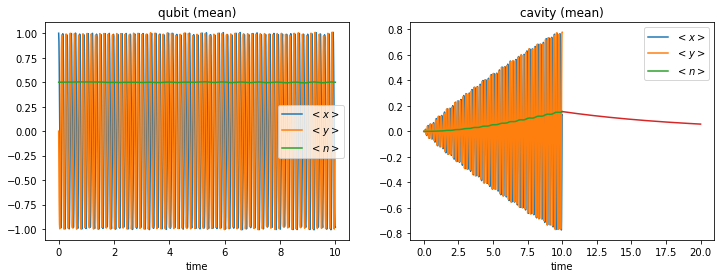

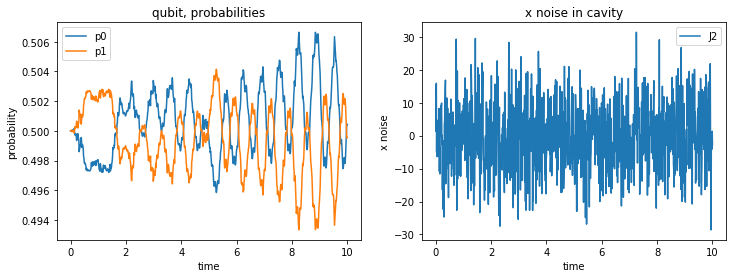

In [16]:
wq = [2*np.pi*6.55334, 2*np.pi*6.165309]
#wq = [2*np.pi*5.0]
wr = 2*np.pi*5.03292
g = 2*np.pi*0.014286


N = 1

q = Qsystem(3, [1, 1, 0], wq)
nr = 7
alpha = 0
#print(wr/2/qfactor)
r = Qsystem(nr, np.exp(-alpha**2/2)*alpha**np.arange(nr)/np.sqrt(scipy.special.factorial(np.arange(nr))), \
            wr, 0.1)
Time = 10
dt = 0.01
steps = round(Time/dt)

#drive = [qubit, resonator]
drive = [Drive(Time, steps, tstart = 0, long = 30, amplitude = 0, shape = 'sin', w = wq[0]), \
         Drive(Time, steps, tstart = 0, long = 10, amplitude = 0.1, shape = 'sin', w = wr)]
print('wr', wr)


noise = 1

print('Time, steps, N, g, noise')
print(Time, steps, N, g, noise)

Jm, J, x, xm, z = SimulateTrajectories(N, q, r, Time, steps, g, noise, drive)
Jm = np.asarray(Jm)
xm = np.asarray(xm)
J = np.asarray(J)
J = J.reshape(J.size//Jm.size, Jm.size)
x = np.asarray(x)
x = x.reshape(x.size//xm.size, xm.size)
z = np.asarray(z)
z = z.reshape(z.size//xm.size, xm.size)
fin = '1 1 0, N=' + str(N) + ' T=' + str(Time) + ', step=' + str(steps) + ', gamma=' + str(0.002) + \
        ', drive 0-100 0.1'
np.savez(fin, Jmean = Jm, J = J, x=x, xm = xm, zq = z)